In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [2]:
def parser(file_name_list,mercator=True,lite=True,lite_kwds=[(610,1500),[260,1160]]):
    # file_name_list contains list of names of files(hd5) from which ghi data will be extracted
    # mercater is for mercator projection of data, Turn it to False if you want normal lat long mapping
    # lite is for region specific plotting, current values set manually for India specifc region, lite_kwds contains these values, first tupel contains x bounds and second tupel contains y bounds
    
    # This part of code gets ghi data from hd5 files and avg them if more than 1 files are provided
    ghi_data=[]
    for file in file_name_list:
        with h5py.File(file,'r') as hdf:
            if lite:
                ghi_data.append(np.squeeze(np.array(hdf.get('GHI_DLY'))[0,lite_kwds[1][0]:lite_kwds[1][1],lite_kwds[0][0]:lite_kwds[0][1]]))
            else:
                ghi_data.append(np.squeeze(np.array(hdf.get('GHI_DLY'))))
    avg_ghi=np.mean(ghi_data,axis=0)
    avg_ghi=avg_ghi*0.2778
    
    # this is mercator projection specific code
    if mercator:

        # These values are taken from original hd5 file and adjuested to fix the allignment specific to india only
        y_co=54-905000
        x_co=5473242.73373-120000
        if lite:
                        # Taking only India specific region
                x_new=np.linspace(x_co,x_co+6378137,1737)[lite_kwds[0][0]:lite_kwds[0][1]]
                y_new=np.linspace(y_co+6356752.314,y_co,1616)[lite_kwds[1][0]:lite_kwds[1][1]]
                # Getting ghi data with one to one mapping from lat long to original x y cordinates
                xt=[]
                yt=[]
                data=[]
                for x in range(0,len(x_new)):#1500
                    for y in range(0,len(y_new)):
                        xt.append(x_new[x])
                        yt.append(y_new[y])
                        data.append(avg_ghi[y,x])
        else:
            # Taking and plotting whole file
            x_new=np.linspace(x_co,x_co+6378137,1737)
            y_new=np.linspace(y_co+6356752.314,y_co,1616) 
            # Getting ghi data with one to one mapping from lat long to original x y cordinates
            xt=[]
            yt=[]
            data=[]
            for x in range(0,len(x_new))
                for y in range(0,len(y_new)):
                    xt.append(x_new[x])
                    yt.append(y_new[y])
                    data.append(avg_ghi[y,x])
                
        # Making dataframe from newly mapped data
        df_ghi=pd.DataFrame()
        df_ghi['x']=xt
        df_ghi['y']=yt
        df_ghi['ghi']=data
    
        #Converting pandas dataframe to geopandas dataframe for visualization
        df_geo=gpd.GeoDataFrame(df_ghi,geometry=gpd.points_from_xy(df_ghi.x,df_ghi.y),crs='epsg:3395')
        return df_geo.to_crs("epsg:4326")

    # Non mercater code taking only lat long bounds and plotting according to them
    else:
        if lite:

            # Taking only India specific region
            # Generating lat long distribution
            x_new=np.linspace(44.0,111.5,1737)[lite_kwds[0][0]:lite_kwds[0][1]]
            y_new=np.linspace(48.1,-8,1616)[lite_kwds[1][0]:lite_kwds[1][1]]
            xt=[]
            yt=[]
            data=[]
            for x in range(0,len(x_new)):#1500
                for y in range(0,len(y_new)):
                    xt.append(x_new[x])
                    yt.append(y_new[y])
                    data.append(avg_ghi[y,x])
        else:

                        # Taking and plotting whole file
        # Generating lat long distribution
            x_new=np.linspace(44.0,111.5,1737)
            y_new=np.linspace(48.1,-8,1616)
            
            # Getting ghi data with one to one mapping from lat long to original x y cordinates
            xt=[]
            yt=[]
            data=[]
            for x in range(0,len(x_new))
                for y in range(0,len(y_new)):
                    xt.append(x_new[x])
                    yt.append(y_new[y])
                    data.append(avg_ghi[y,x])
        # Making dataframe from newly mapped data
        df_ghi=pd.DataFrame()
        df_ghi['x']=xt
        df_ghi['y']=yt
        df_ghi['ghi']=data
    
        #Converting pandas dataframe to geopandas dataframe for visualization
        df_geo=gpd.GeoDataFrame(df_ghi,geometry=gpd.points_from_xy(df_ghi.x,df_ghi.y),crs='EPSG:4326')
        return df_geo

In [3]:
# loading one day file
df_avg=parser(['3RIMG_07APR2024_0015_L3C_GHI_DLY_V01R00.h5'])
#shape file which includes district level boundries on india , Source from cenus data 2011
df_district=gpd.read_file('district.shp')
# shape file which only contains latest state level boundries, source internet
df_states=gpd.read_file('states.shp')

In [4]:
# state codes in df_district shape file 
state_dictionary={
    'Jammu Kashmir':'01',
    'Himachal':'02',
    'Punjab':'03',
    'Leh':'04',
    'Utrakhand':'05',
    'Haryana':'06',
    'Delhi':'07',
    'Rajasthan':'08',
    'Uttar Pradesh':'09',
    'Bihar':'10',
    'Sikkam':'11',
    'Arunachal Pradesh':'12',
    'Nagaland':'13',
    'Manipur':'14',
    'Mizoram':'15',
    'Tripura':'16',
    'Meghlaya':'17',
    'Assam':'18',
    'West Bengal':'19',
    'Jharkhand':'20',
    'Odisha':'21',
    'Chhatisgardh':'22',
    'Madhya Pradesh':'23',
    'Gujarat':'24',
    'Maharashtra':'27',
    'Andhra Pradesh':'28',
    'Karnatka':'29',
    'Goa':'30',
    'Kerla':'32',
    'TamilNadu':'33'
}

In [5]:
def plot_india(df_ghi,df_states,df_district,outer_region=True,figsize=(6,6),filter=False,filter_value=(),max_min=False,title=False,title_name='',save=False,file_name='',show_output=True,df_out=False,pointsize=5):
    # This function will plot or save india specific map with or without outer region.
    # if filter set to True and filter_value tupel given values like (0,6) then only ghi >6 will be plotted for (1,6) ghi less than 6 will be plotted
    # outer region of india including sea and other countries ghi will be shown if set True
    # min max will display min and max value of ghi with district name , only works when outer_region is False, India specific only
    # point size is for setting size of point which will be shown
    
    # filtering ghi values as per given condition
    if filter:
        mode,value=filter_value
        if int(mode)==0:
            df_ghi=df_ghi[df_ghi['ghi']>value]
        else:
            df_ghi=df_ghi[df_ghi['ghi']<value]
    
    # if outer region True this part will be excuuted , max min willnot work.
    if outer_region:
        fig,axs=plt.subplots(figsize=figsize)
        # plotting whole ghi
        df_ghi.plot(df_ghi['ghi'],ax=axs,legend=True,vmin=0,vmax=10,legend_kwds={"label": "GHI",'shrink': 0.5},markersize=pointsize)
        # adding india state boundry layer
        df_states.plot(ax=axs,edgecolor='black',color='none')
        if title:
            plt.title(title_name)
        if save:
            plt.savefig(file_name)
        if show_output==False:
            plt.close()
    
    # if outer region is false than this part
    if not outer_region:
        # finding common ghi points which lies inside indian teritery
        common=gpd.overlay(df_ghi,df_district,how='intersection')
        fig,axs=plt.subplots(figsize=figsize)
        #plotting common points
        common.plot(common['ghi'],ax=axs,legend=True,vmin=0,vmax=10,legend_kwds={"label": "GHI",'shrink': 0.5},markersize=pointsize)
        # plotting indian teritory
        df_states.plot(ax=axs,edgecolor='black',color='none')
        #finding min max ghi with loation in indian teritory
        max=common[common['ghi']==common['ghi'].max()]
        min=common[common['ghi']==common['ghi'].min()]
        max_val,max_dis,min_val,min_dis=round(max['ghi'].tolist()[0],2),max['d_name'].tolist()[0],round(min['ghi'].tolist()[0],2),min['d_name'].tolist()[0]
        info='Max GHI(*) ='+str(max_val)+'\nDistrict-'+str(max_dis)+'\nMin GHI(o) ='+str(min_val)+'\nDistrict-'+str(min_dis)
        if max_min:
            #plotting min_max locations on indian map
            max.plot(ax=axs,color='red',markersize=figsize[0]*8,marker='*')
            min.plot(ax=axs,color='red',markersize=figsize[0]*8)
            axs.text(90,35,s=info,horizontalalignment='center')
        if title:
            plt.title(title_name)
        if save:
            plt.savefig(file_name,bbox_inches='tight')
        if show_output==False:
            plt.close()

In [6]:
def max_min_ghi(df_ghi,df_district,state=False,state_id='06'):
    #This function will return max and min value of ghi with its district for both india of specific state or list of states
    # if state is False than will only work for India
    if state:
        temp_df=pd.DataFrame()
        for state in state_id:
            df_dis=df_district[df_district['pc11_s_id']==state]
            df_dis=df_dis.dissolve(by='pc11_s_id')
            common=gpd.overlay(df_ghi,df_dis,how='intersection')
            df=common[(common['ghi']==common['ghi'].max())|(common['ghi']==common['ghi'].min())].reset_index(drop=True)
            df_1=pd.DataFrame({'state_id':[state,state],'label':[0,1]})
            df_1=pd.concat((df,df_1),axis=1)
            temp_df=pd.concat((temp_df,df_1),ignore_index=True)
        return temp_df.reset_index(drop=True)
    else:
        common=gpd.overlay(df_ghi,df_district,how='intersection')
        temp_df=common[(common['ghi']==common['ghi'].max())|(common['ghi']==common['ghi'].min())]
        return temp_df.reset_index(drop=True)

In [15]:
test=max_min_ghi(df_avg,df_district,state=False,state_id=['07','06','05'])

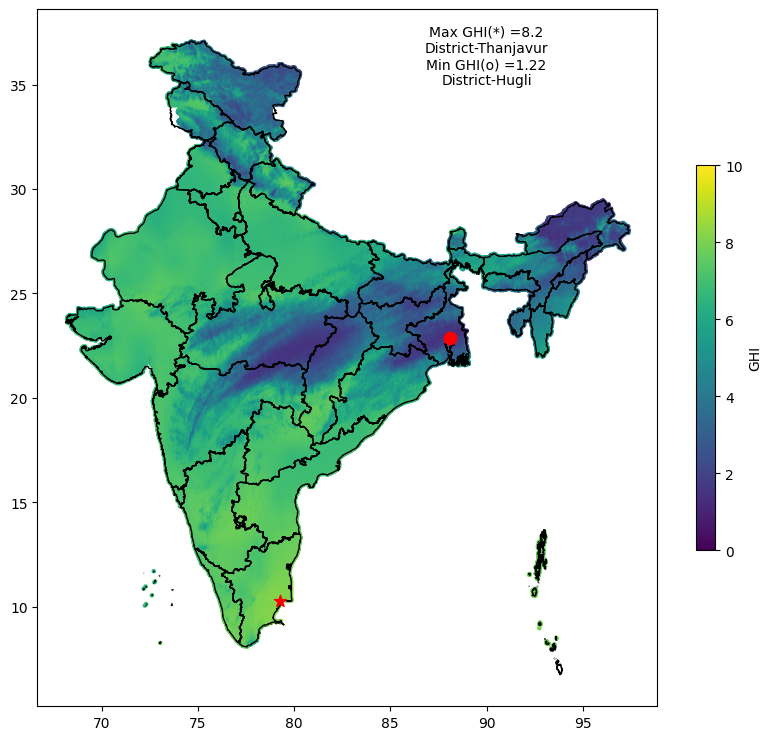

In [7]:
df_avg=parser(['3RIMG_07APR2024_0015_L3C_GHI_DLY_V01R00.h5'])
plot_india(df_avg,df_states,df_district,outer_region=False,filter=False,filter_value=(0,7),max_min=True,figsize=(10,10))

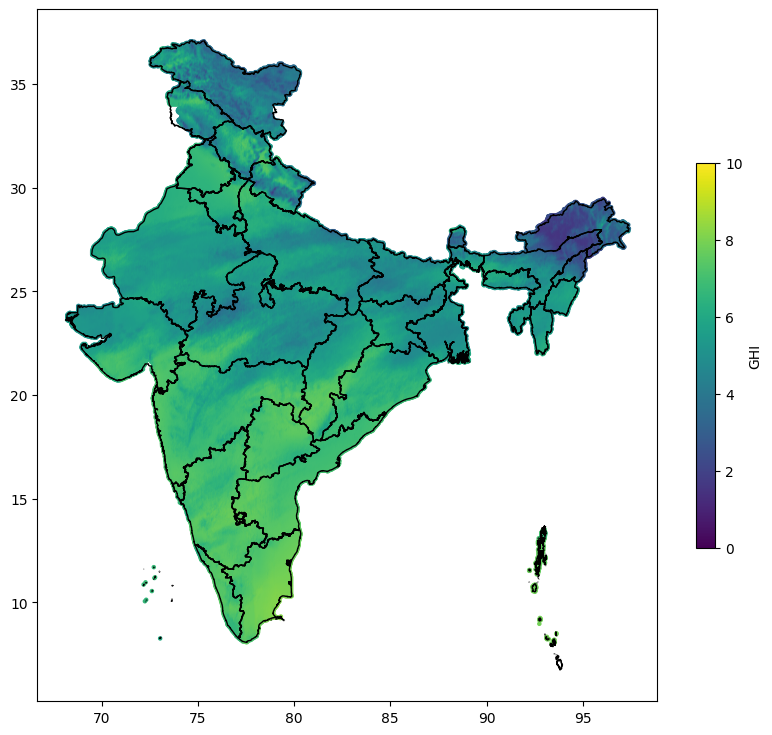

In [8]:
df_avg=parser(['3RIMG_05APR2024_0015_L3C_GHI_DLY_V01R00.h5','3RIMG_06APR2024_0015_L3C_GHI_DLY_V01R00.h5','3RIMG_07APR2024_0015_L3C_GHI_DLY_V01R00.h5'])
plot_india(df_avg,df_states,df_district,outer_region=False,filter=False,filter_value=(0,7),max_min=False,figsize=(10,10))
#df_avg.plot(df_avg['ghi'])

In [8]:
for fname,no in zip(['3RIMG_05APR2024_0015_L3C_GHI_DLY_V01R00.h5','3RIMG_06APR2024_0015_L3C_GHI_DLY_V01R00.h5','3RIMG_07APR2024_0015_L3C_GHI_DLY_V01R00.h5'],[5,6,7]):
    df_ghi=parser([fname])
    plot_india(df_ghi,df_states,df_district,outer_region=True,figsize=(10,10),save=True,file_name='normal_'+str(no)+'+_.png',show_output=False)
    #print(fname)

In [20]:
def state_ghi(df_ghi,df_base,state_id,figsize=(6,6),filter=False,filter_value=(),district_label=False,max_min=False,title=False,title_name='',save=False,file_name='',show_output=True,df_out=False,pointsize=5,info_location=0,info_offset=(0,0)):
    # This function will plot state specific region with ghi and filter depending upon filter_values
    # district labels can be turned on or off
    df_state=df_base[df_base['pc11_s_id']==state_id]
    if filter:
        mode,value=filter_value
        if int(mode)==0:
            df_ghi=df_ghi[df_ghi['ghi']>value]
        else:
            df_ghi=df_ghi[df_ghi['ghi']<value]
    common=gpd.overlay(df_ghi,df_state,how='intersection')
    fig,axes=plt.subplots(figsize=figsize)
    common.plot(common['ghi'],ax=axes,legend=True,vmin=0,vmax=10,legend_kwds={"label": "GHI",'shrink': 0.5},markersize=pointsize)
    df_state.plot(color='none',edgecolor='black',ax=axes)
    max=common[common['ghi']==common['ghi'].max()]
    min=common[common['ghi']==common['ghi'].min()]
    max_val,max_dis,min_val,min_dis=round(max['ghi'].tolist()[0],2),max['d_name'].tolist()[0],round(min['ghi'].tolist()[0],2),min['d_name'].tolist()[0]
    if district_label:
        for idx, row in df_state.iterrows():
            axes.text(row.geometry.representative_point().coords[:][0][0], row.geometry.representative_point().coords[:][0][1],s=row['d_name'],horizontalalignment='center',bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 0, 'edgecolor':'none'})
    if max_min:
        max.plot(ax=axes,color='red',markersize=figsize[0]*8,marker='*')
        min.plot(ax=axes,color='red',markersize=figsize[0]*8)
        info='Max GHI(*) ='+str(max_val)+'\nDistrict-'+str(max_dis)+'\nMin GHI(o) ='+str(min_val)+'\nDistrict-'+str(min_dis)
        if info_location==0:
            x=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][0]).min()-info_offset[0]
            y=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][1]).min()-info_offset[1]
        elif info_location==1:
            x=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][0]).max()-info_offset[0]
            y=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][1]).min()-info_offset[1]
        elif info_location==1:
            x=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][0]).min()-info_offset[0]
            y=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][1]).max()-info_offset[1]
        else:
            x=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][0]).max()-info_offset[0]
            y=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][1]).max()-info_offset[1]
        axes.text(x,y,s=info,horizontalalignment='center')
    if title:
        plt.title(title_name)
    if save:
        plt.savefig(file_name,bbox_inches='tight')
    if show_output==False:
        plt.close()
    if df_out:
        return common

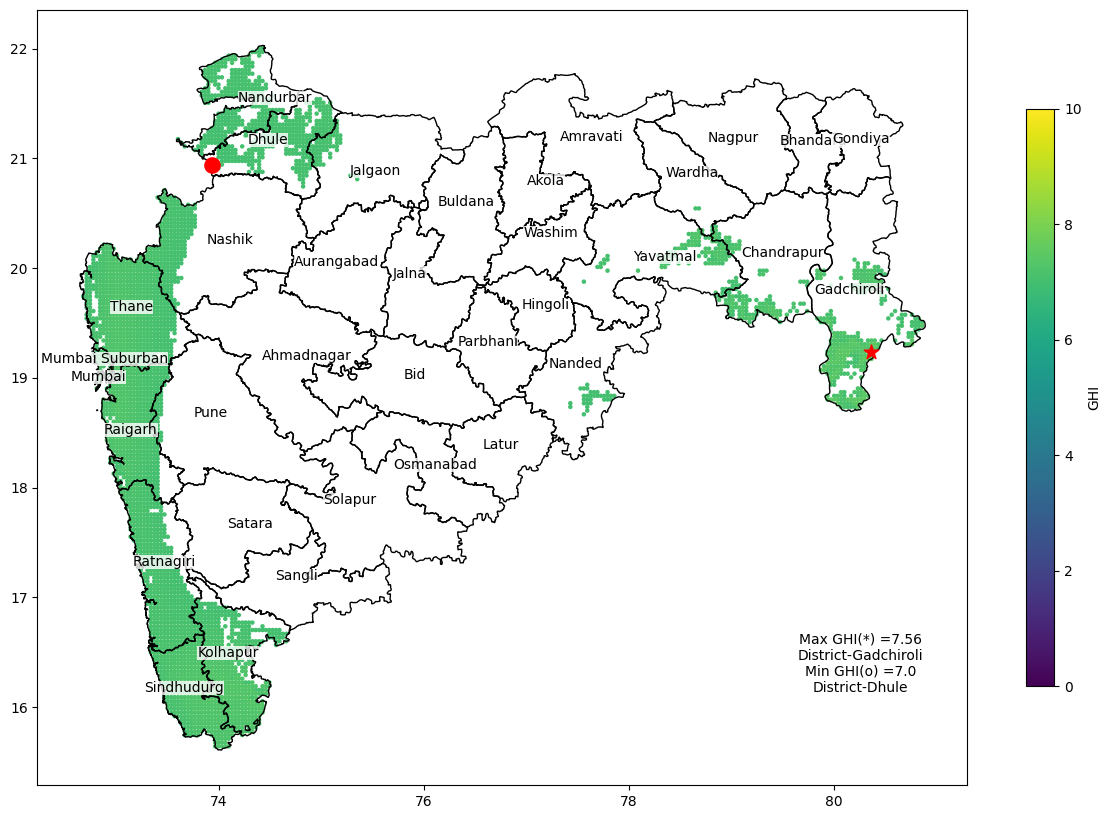

In [21]:
state_ghi(df_avg,df_district,'27',figsize=(15,15),district_label=True,max_min=True,save=False,file_name='raj',show_output=True,filter=True,filter_value=(0,7),info_location=1)


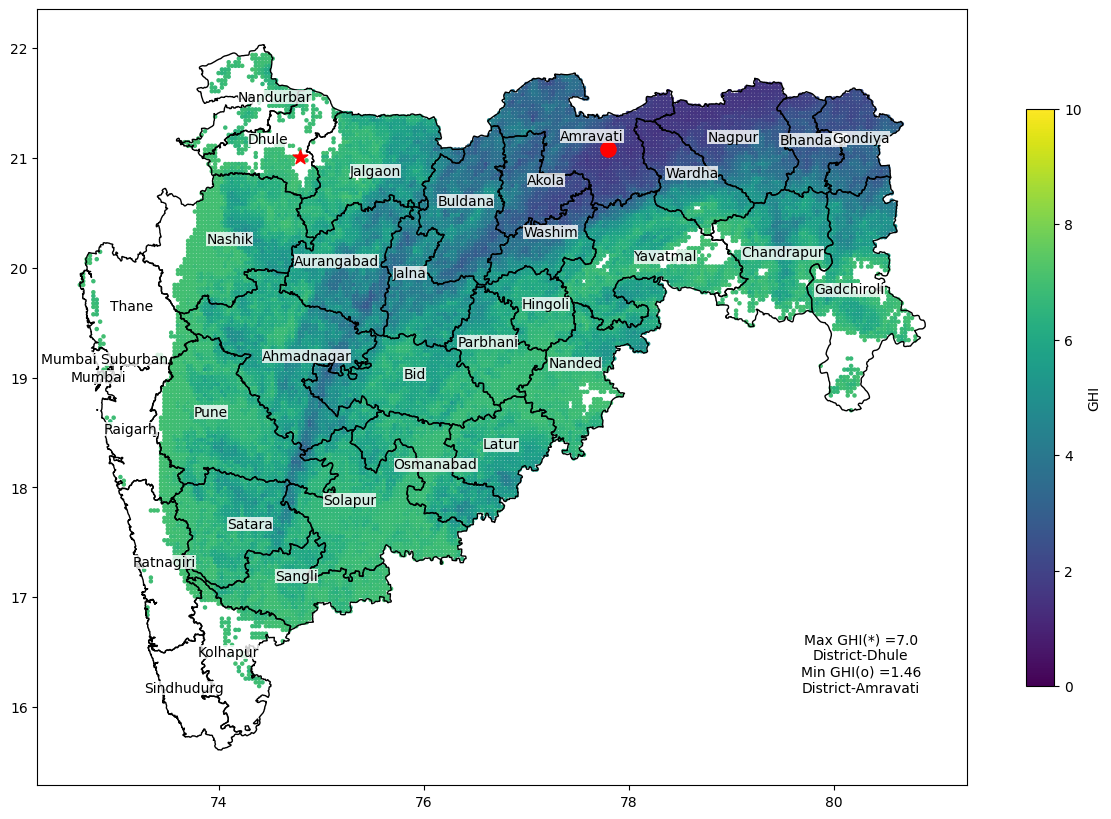

In [22]:
state_ghi(df_avg,df_district,'27',figsize=(15,15),district_label=True,max_min=True,save=False,file_name='raj',show_output=True,filter=True,filter_value=(1,7),info_location=1)


In [25]:
def multi_state(df_ghi,df_base,id_list,figsize=(6,6),filter=False,filter_value=(),max_min=False,title=False,title_name='',save=False,file_name='',show_output=True,df_out=False,show_district=False,pointsize=5,info_location=0,info_offset=(0,0)):
    # This function is for plotting mutiple states together
    df_state=pd.DataFrame()
    for id in id_list:
        df_state=pd.concat((df_state,df_base[df_base['pc11_s_id']==id]),ignore_index=True)
    
    if filter:
        mode,value=filter_value
        if mode==0:
            df_ghi=df_ghi[df_ghi['ghi']>value]
        else:
            df_ghi=df_ghi[df_ghi['ghi']<value]
    common=gpd.overlay(df_ghi,df_state,how='intersection')
    max=common[common['ghi']==common['ghi'].max()]
    min=common[common['ghi']==common['ghi'].min()]
    max_val,max_dis,min_val,min_dis=round(max['ghi'].tolist()[0],2),max['d_name'].tolist()[0],round(min['ghi'].tolist()[0],2),min['d_name'].tolist()[0]
    fig,axes=plt.subplots(figsize=figsize)
    common.plot(common['ghi'],ax=axes,legend=True,vmin=0,vmax=10,legend_kwds={"label": "GHI",'shrink': 0.3},markersize=pointsize)
    if not show_district:
        df_state=df_state.dissolve(by='pc11_s_id')
    df_state.plot(color='none',edgecolor='black',ax=axes)
    if max_min:
        max.plot(ax=axes,color='red',markersize=figsize[0]*8,marker='*')
        min.plot(ax=axes,color='red',markersize=figsize[0]*8)
        info='Max GHI(*) ='+str(max_val)+'\nDistrict-'+str(max_dis)+'\nMin GHI(o) ='+str(min_val)+'\nDistrict-'+str(min_dis)
        if info_location==0:
            x=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][0]).min()-info_offset[0]
            y=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][1]).min()-info_offset[1]
        elif info_location==1:
            x=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][0]).max()-info_offset[0]
            y=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][1]).min()-info_offset[1]
        elif info_location==1:
            x=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][0]).min()-info_offset[0]
            y=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][1]).max()-info_offset[1]
        else:
            x=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][0]).max()-info_offset[0]
            y=df_state['geometry'].apply(lambda x:x.representative_point().coords[:][0][1]).max()-info_offset[1]
        axes.text(x,y,s=info,horizontalalignment='center')
    if title:
        plt.title(title_name)
    if save:
        plt.savefig(file_name,bbox_inches='tight')
    if show_output==False:
        plt.close()
    if df_out:
        return common

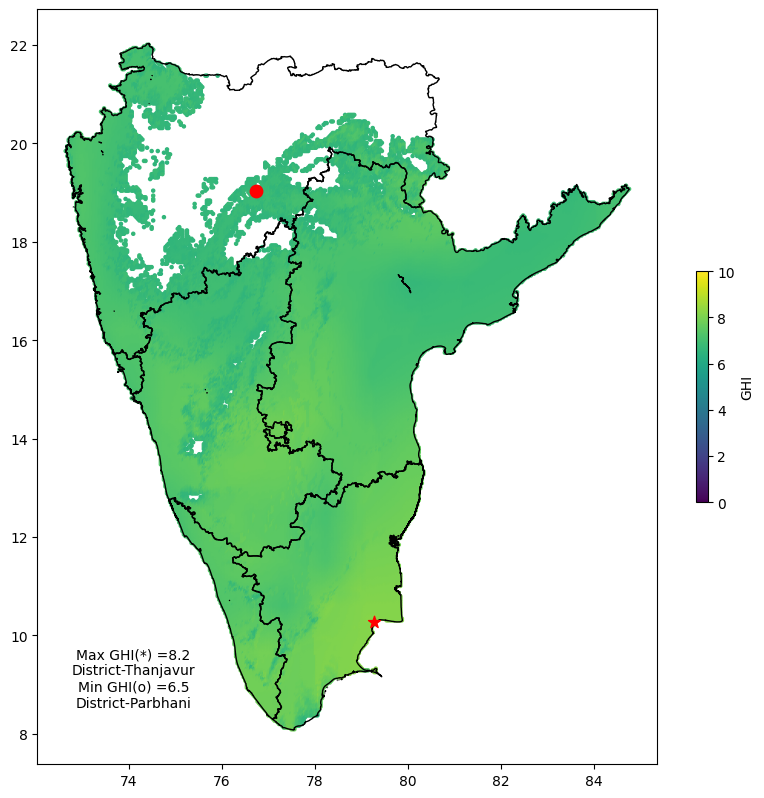

In [26]:
multi_state(df_avg,df_district,['27','28','29','32','33','30'],figsize=(10,10),filter=True,filter_value=(0,6.5),max_min=True,info_location=0,info_offset=(0,2))

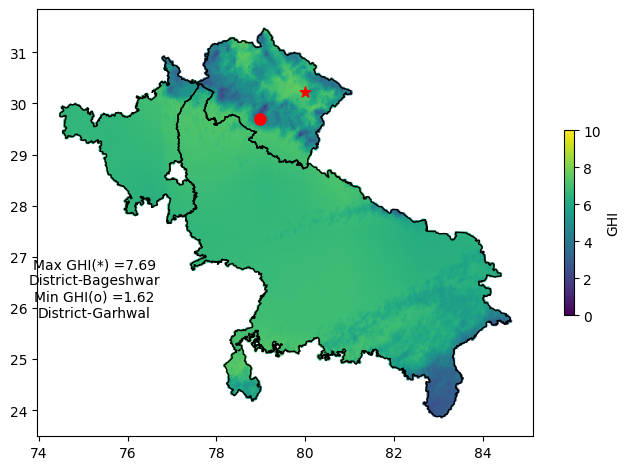

In [29]:
multi_state(df_avg,df_district,['05','06','09'],figsize=(8,8),filter=False,filter_value=(1,6.5),max_min=True,info_location=0,info_offset=(1,1.3),pointsize=3)

<Axes: >

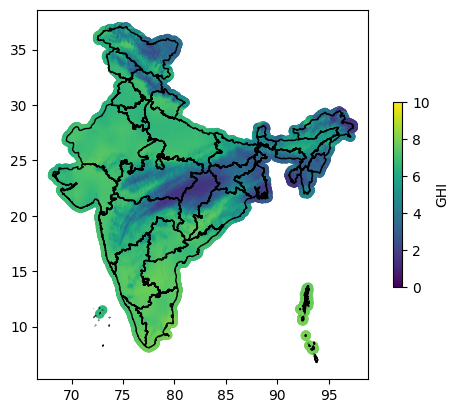

In [45]:
fig,axs=plt.subplots()
common.plot(common['ghi'],ax=axs,legend=True,vmin=0,vmax=10,legend_kwds={"label": "GHI",'shrink': 0.5})#,markersize=pointsize)
df_states.plot(ax=axs,edgecolor='black',color='none')

In [49]:
common[common['ghi']==common['ghi'].min()]

,x,y,ghi,pc11_s_id,pc11_d_id,d_name,geometry
199110,91.358871,23.124211,1.297608,16,290,South Tripura,POINT (91.35887 23.12421)
